Convolutional Variational Autoencoder (CVAE) is expected to be able to encode various features of complex bunch configurations.

In [334]:
# Autoload when refreshing notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('../../')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN, extract_processed_images, apply_centroid_correction,apply_tcav_zeroing_filter, MLP
from Python_Functions.cvae import CVAE, vae_loss, smooth_cvae_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Preprocessed Images

In [372]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from scipy.io import loadmat 
import re
import os 
# Assumed: commonIndexFromSteps, extractDAQBSAScalars, and other helper functions are available

# ----------------------------------------------------------------------
# 1. Define the list of (experiment, runname, step_identifier) pairs to load
# ----------------------------------------------------------------------
run_pairs = [
    ('E300', '12431', 1),  # Example pairs, modify this list
    ('E300', '12427', 1),
    #('E300', '12431', 1),
    #('E338', '12710', 1)
    # Add more pairs here...
]

# ----------------------------------------------------------------------
# 2. Initialize lists for concatenation
# ----------------------------------------------------------------------
all_images = []
all_predictors = []
all_indices = []

print("Starting multi-run data loading and concatenation...")

# ----------------------------------------------------------------------
# 3. Loop through runs, load data, and concatenate
# ----------------------------------------------------------------------
charge_merged = []
for experiment, runname, step_id in run_pairs:
    
    # --- A. Load Processed LPSImage Data and Good Shots Index ---
    pickle_filename = f'../../data/processed/LPSImage_goodshots_{experiment}_{runname}_{step_id}.pkl'

    try:
        with open(pickle_filename, 'rb') as f:
            data = pickle.load(f)
        
        LPSImage_good = data['LPSImage'] # Filtered LPS images
        # This 'goodShots' index is relative to the phase-filtered data (all_idx).
        goodShots_scal_common_index = data['scalarCommonIndex'] 
        
        print(f"Loaded {experiment}_{runname}: LPSImage shape {LPSImage_good.shape}")
        
    except FileNotFoundError:
        print(f"Skipping {experiment}_{runname}: Pickle file not found at {pickle_filename}")
        continue
    
    # --- B. Load and Filter Predictor Data (BSA Scalars) ---
    
    # 1. Load data_struct
    dataloc = f'../../data/raw/{experiment}/{experiment}_{runname}/{experiment}_{runname}.mat'
    try:
        mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
        data_struct = mat['data_struct']
    except FileNotFoundError:
        print(f"Skipping {experiment}_{runname}: .mat file not found at {dataloc}")
        continue

    # 2. Extract full BSA scalars (filtered by step_list if needed)
    # Don't filter by common index here, we'll do it with the goodShots scalar common index loaded from the file
    bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct, filter_index=False)
    bsaScalarData = apply_tcav_zeroing_filter(bsaScalarData, bsaVars)

    # 3. 

    # 5. Filter BSA data using the final index
    # goodShots_scal_common_index is 1 based indexing from MATLAB, convert to 0 based
    bsaScalarData_filtered = bsaScalarData[:, goodShots_scal_common_index - 1]
    
    isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
    if isChargePV:
        # Extract charge data
        pvidx = [i for i, val in enumerate(isChargePV) if val]
        charge = bsaScalarData[pvidx, :][0] * 1.6e-19  # in C 
        charge_filtered = charge[goodShots_scal_common_index - 1]
    # 6. Construct the predictor array
    predictor_current = np.vstack(bsaScalarData_filtered).T
    
    # C. Append to master lists
    all_images.append(LPSImage_good)
    all_predictors.append(predictor_current)
    charge_merged.append(charge_filtered)
    
# ----------------------------------------------------------------------
# 4. Concatenate and finalize arrays
# ----------------------------------------------------------------------

# Set image half dimensions (should match preprocessing)
yrange = 100
xrange = 100

# Combine all data arrays from the runs
images_tmp = np.concatenate(all_images, axis=0)
images_tmp = images_tmp.reshape(images_tmp.shape[0], 2*yrange, 2*xrange)
predictor_tmp = np.concatenate(all_predictors, axis=0)
charge = np.concatenate(charge_merged, axis=0)


print("\n--- Final Concatenated Data Shapes ---")
print(f"Total LPS Images (images): {images_tmp.shape}")
print(f"Total Predictors (predictor): {predictor_tmp.shape}")


Starting multi-run data loading and concatenation...
Loaded E300_12431: LPSImage shape (753, 40000)
Applying filter: Setting 501 samples of TCAV_LI20_2400_P to 0 where TCAV_LI20_2400_A < 1.0
Loaded E300_12427: LPSImage shape (926, 40000)
Applying filter: Setting 504 samples of TCAV_LI20_2400_P to 0 where TCAV_LI20_2400_A < 1.0

--- Final Concatenated Data Shapes ---
Total LPS Images (images): (1679, 200, 200)
Total Predictors (predictor): (1679, 130)


### Phase selection, flip images

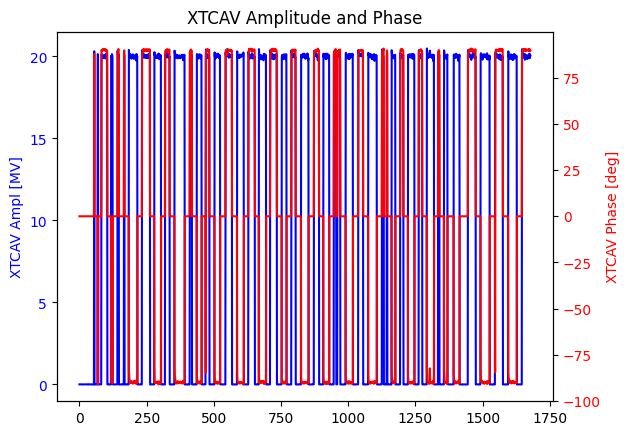

In [373]:
ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = predictor_tmp[:, ampl_idx]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = predictor_tmp[:, phase_idx]
xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting
# 
near_minus_90_idx = np.where((xtcavPhase >= -90.55) & (xtcavPhase <= -89.55))[0]
near_plus_90_idx = np.where((xtcavPhase >= 89.55) & (xtcavPhase <= 90.55))[0]
lps_idx = near_minus_90_idx.tolist() + near_plus_90_idx.tolist()
# Flip image horizontally for -90 deg phase
images_flipped = images_tmp.copy()
images_flipped[near_minus_90_idx, :, :] = np.flip(images_tmp[near_minus_90_idx, :, :], axis=2)

fig, ax1 = plt.subplots()
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('XTCAV Amplitude and Phase')
plt.show()

### Exclude BSA Variables

In [374]:
from Python_Functions.functions import exclude_bsa_vars
excluded_var_idx = exclude_bsa_vars(bsaVars)
predictor_tmp_cleaned = np.delete(predictor_tmp, excluded_var_idx, axis=1)[lps_idx, :]
print(f"Predictor shape after excluding variables: {predictor_tmp_cleaned.shape}")

LPSimg_prezoom = images_flipped[lps_idx]
charge_filtered = charge[lps_idx]
print(f"LPS Image shape after filtering: {LPSimg_prezoom.shape}")


Excluding BSA Variables: ['TCAV_LI20_2400_A', 'TCAV_LI20_2400_P', 'TORO_LI20_3163_TMIT', 'TORO_LI20_3255_TMIT', 'BPMS_LI20_3156_X', 'BPMS_LI20_3156_Y', 'BPMS_LI20_3156_TMIT', 'BPMS_LI20_3218_X', 'BPMS_LI20_3218_Y', 'BPMS_LI20_3218_TMIT', 'BPMS_LI20_3265_X', 'BPMS_LI20_3265_Y', 'BPMS_LI20_3265_TMIT', 'BPMS_LI20_3315_X', 'BPMS_LI20_3315_Y', 'BPMS_LI20_3315_TMIT', 'PMT_LI20_3179_QDCRAW', 'PMT_LI20_3350_QDCRAW', 'PMT_LI20_3360_QDCRAW', 'WIRE_LI20_3179_POSN']
Excluded variable indices: [104, 105, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 129]
Predictor shape after excluding variables: (608, 110)
LPS Image shape after filtering: (608, 200, 200)


### Calibration

In [375]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8
# Flags
# If enabled, GMM fit is weighted to predict better current profile rather than overall image fit
do_current_profile = True

In [376]:
print(data_struct.scalars.nonBSA_List_S20Magnets.LI20_XCOR_3086_BACT)

[0.01091627 0.01091627 0.01091627 ... 0.01092081 0.01092081 0.01092081]


### Image Resize

In [377]:
# Interpolate LPS images to square pixels for CVAE training.
# 2* yrange, 2* xrange to 200x200
# CVAE model assumes square images with 200x200 pixels, forced by convolutional layers
from scipy.ndimage import zoom
LPSimg_resized = np.zeros((LPSimg_prezoom.shape[0], 200, 200), dtype=LPSimg_prezoom.dtype)
for i in range(LPSimg_prezoom.shape[0]):
    LPSimg_resized[i] = zoom(LPSimg_prezoom[i], (200/(2*yrange), 200/(2*xrange)), order=1)
LPSimg = LPSimg_resized

### CVAE

In [378]:

# Number of components for the CVAE.
# Too low, the model will not capture the complexity of the data.
# Too high, the prediction task becomes too difficult.
NCOMP = 14

INPUT_CHANNELS = 1 # Assuming LPSimg is grayscale/single-channel data
# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# 2. Initialize Model and Optimizer
model_cvae = CVAE(latent_dim=NCOMP).to(device)
optimizer = torch.optim.Adam(model_cvae.parameters(), lr=1e-3)

# LPSimg is a numpy array of shape [n_samples, 200, 200].
BATCH_SIZE = 16
# ---------------------------------------------------

# Convert numpy data to PyTorch Tensor, add the Channel dimension (C=1)
LPSimg_tensor = torch.from_numpy(LPSimg).unsqueeze(1).float()
LPSimg_tensor /= LPSimg_tensor.max()
# Create a simple DataLoader for the data
from torch.utils.data import TensorDataset, DataLoader

from Python_Functions.cvae import proj_vae_loss
dataset = TensorDataset(LPSimg_tensor)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. Training Loop
N_EPOCHS = 14
print("\nStarting training loop ({} epochs)...".format(N_EPOCHS))

for epoch in range(1, N_EPOCHS + 1):
    total_loss = 0
    for batch_idx, (data,) in enumerate(data_loader):
        data = data.to(device)
        
        # Forward pass
        reconstruction, mu, logvar = model_cvae(data)
        
        # Calculate loss
        # Like normal loss, vae_loss is not great for predicting LPS with small isolated features.
        # Using projection loss to improve reconstruction of small features, which are enhanced logarithmically in the projection.
        loss = proj_vae_loss(reconstruction, data, mu, logvar, strength=0.5)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch}/{N_EPOCHS}, Average VAE Loss: {avg_loss:.4f}")

Using device: cpu

Starting training loop (14 epochs)...
Epoch 1/14, Average VAE Loss: 5151.7645
Epoch 2/14, Average VAE Loss: 1395.8827
Epoch 3/14, Average VAE Loss: 910.4528
Epoch 4/14, Average VAE Loss: 735.4155
Epoch 5/14, Average VAE Loss: 651.6881
Epoch 6/14, Average VAE Loss: 604.6206
Epoch 7/14, Average VAE Loss: 576.2767
Epoch 8/14, Average VAE Loss: 559.7115
Epoch 9/14, Average VAE Loss: 545.9069
Epoch 10/14, Average VAE Loss: 536.7706
Epoch 11/14, Average VAE Loss: 529.4206
Epoch 12/14, Average VAE Loss: 524.0572
Epoch 13/14, Average VAE Loss: 519.7498
Epoch 14/14, Average VAE Loss: 516.1240



🚀 Starting NCOMP Optimization (Outer Loop)
Testing NCOMP from 8 to 18 (Total 6 candidates)...

--- Testing NCOMP = 8 (Latent Dimension) ---
  -> Repetition 1/10...
    [E1] Loss: 132517.7875 | Strength: 0.00
    [E2] Loss: 4269.1802 | Strength: 0.00
    [E3] Loss: 1967.2336 | Strength: 0.00
    [E4] Loss: 1323.6287 | Strength: 0.00
    [E5] Loss: 1033.2173 | Strength: 0.00
    [E6] Loss: 870.5846 | Strength: 0.00
    [E7] Loss: 776.9136 | Strength: 0.00
    [E8] Loss: 718.4876 | Strength: 0.00
    [E9] Loss: 675.8941 | Strength: 0.00
    [E10] Loss: 647.0297 | Strength: 0.00
  -> Repetition 2/10...
    [E1] Loss: 13632.0275 | Strength: 0.00
    [E2] Loss: 3453.7760 | Strength: 0.00
    [E3] Loss: 1727.6380 | Strength: 0.00
    [E4] Loss: 1212.6888 | Strength: 0.00
    [E5] Loss: 964.2985 | Strength: 0.00
    [E6] Loss: 831.3448 | Strength: 0.00
    [E7] Loss: 751.3548 | Strength: 0.00
    [E8] Loss: 699.5564 | Strength: 0.00
    [E9] Loss: 661.6025 | Strength: 0.00
    [E10] Loss: 635

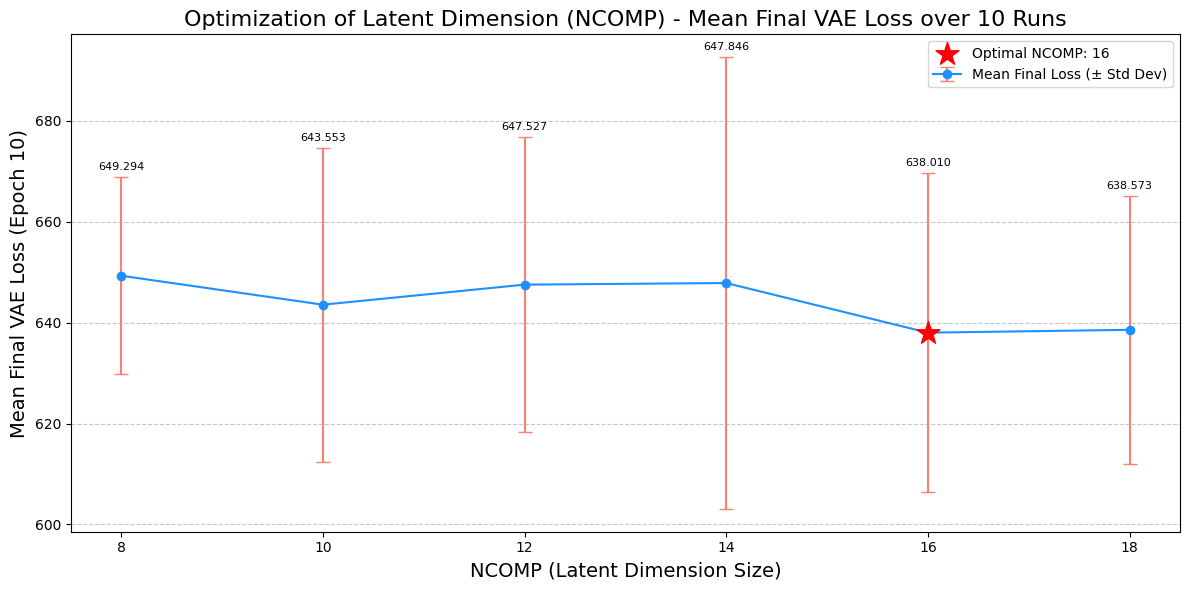


--- Final Recommendation ---
Based on the lowest mean final loss, the optimal NCOMP is: 16
Corresponding Mean Loss: 638.0095
Check the generated plot for the full visualization of the trade-off between dimensionality and loss stability.


In [366]:
import statistics
BATCH_SIZE = 16
N_EPOCHS = 10
LEARNING_RATE = 1e-3
MIN_STRENGTH, MAX_STRENGTH = 0.0, 0.0 # Strength variation range
# Convert numpy data to PyTorch Tensor, add the Channel dimension (C=1)
LPSimg_tensor = torch.from_numpy(LPSimg).unsqueeze(1).float()
LPSimg_tensor /= LPSimg_tensor.max()

# Create a simple DataLoader for the data
dataset = TensorDataset(LPSimg_tensor)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Hyperparameter Search Setup ---
# NCOMP must be varied by step size of 1, varying from 8 to some number.
NCOMP_CANDIDATES = list(range(8, 20, 2))

best_ncomp = None
min_final_loss = float('inf')
results = {}
all_ncomp_results = {}

print("\n🚀 Starting NCOMP Optimization (Outer Loop)")
print(f"Testing NCOMP from {NCOMP_CANDIDATES[0]} to {NCOMP_CANDIDATES[-1]} (Total {len(NCOMP_CANDIDATES)} candidates)...")
# Gather statistics for each NCOMP by training a CVAE and recording final loss many times.
N_REPETITIONS = 10 

for NCOMP in NCOMP_CANDIDATES:
    print(f"\n--- Testing NCOMP = {NCOMP} (Latent Dimension) ---")
    
    # List to store the final loss from each of the 10 repetitions
    final_losses_for_ncomp = []
    
    for run in range(1, N_REPETITIONS + 1):
        print(f"  -> Repetition {run}/{N_REPETITIONS}...")
        
        # Initialize Model and Optimizer for the current NCOMP and run
        model_cvae = CVAE(latent_dim=NCOMP).to(device)
        optimizer = optim.Adam(model_cvae.parameters(), lr=LEARNING_RATE)
        
        total_loss_history = []
        
        # Training Loop (Inner Loop)
        for epoch in range(1, N_EPOCHS + 1):
            # Dynamic 'strength' scheduling: linear increase from MIN_S to MAX_S
            # strength will be MIN_S at epoch 1 and MAX_S at epoch N_EPOCHS
            strength = MIN_STRENGTH + (MAX_STRENGTH - MIN_STRENGTH) * ((epoch - 1) / max(1, N_EPOCHS - 1))
            strength = np.clip(strength, 0, 1) # Ensure bounded
            
            total_loss = 0
            model_cvae.train()
            
            for batch_idx, (data,) in enumerate(data_loader):
                data = data.to(device)

                reconstruction, mu, logvar = model_cvae(data)
                
                # Calculate loss with dynamic strength
                loss = proj_vae_loss(reconstruction, data, mu, logvar, strength=strength)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(dataset)
            total_loss_history.append(avg_loss)
            
            # Optional: print epoch details for diagnostics
            print(f"    [E{epoch}] Loss: {avg_loss:.4f} | Strength: {strength:.2f}")

        # Record the final loss of this run (last epoch's loss)
        final_losses_for_ncomp.append(total_loss_history[-1])
    
    # Calculate statistics for the 10 runs
    mean_loss = statistics.mean(final_losses_for_ncomp)
    std_dev_loss = statistics.stdev(final_losses_for_ncomp) if len(final_losses_for_ncomp) > 1 else 0.0
    
    all_ncomp_results[NCOMP] = {
        'mean_final_loss': mean_loss,
        'std_dev': std_dev_loss,
        'losses': final_losses_for_ncomp
    }
    
    print(f"  Summary for NCOMP={NCOMP}: Mean Final Loss={mean_loss:.4f}, Std Dev={std_dev_loss:.4f}")

# --- 4. Plotting the Results ---
print("\nGenerating results plot...")

ncomp_values = list(all_ncomp_results.keys())
mean_losses = [r['mean_final_loss'] for r in all_ncomp_results.values()]
std_devs = [r['std_dev'] for r in all_ncomp_results.values()]

# Identify the best NCOMP
best_ncomp_idx = np.argmin(mean_losses)
best_ncomp = ncomp_values[best_ncomp_idx]
best_loss = mean_losses[best_ncomp_idx]

plt.figure(figsize=(12, 6))

# Plot mean final loss with error bars
plt.errorbar(ncomp_values, mean_losses, yerr=std_devs, 
             fmt='-o', color='dodgerblue', ecolor='salmon', 
             capsize=5, label='Mean Final Loss (± Std Dev)')

# Highlight the optimal NCOMP
plt.scatter([best_ncomp], [best_loss], 
            color='red', marker='*', s=300, 
            label=f'Optimal NCOMP: {best_ncomp}', zorder=5)

# Add annotations
for i, ncomp in enumerate(ncomp_values):
    plt.annotate(f'{mean_losses[i]:.3f}', (ncomp, mean_losses[i] + std_devs[i] + 0.001), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.title('Optimization of Latent Dimension (NCOMP) - Mean Final VAE Loss over 10 Runs', fontsize=16)
plt.xlabel('NCOMP (Latent Dimension Size)', fontsize=14)
plt.ylabel(f'Mean Final VAE Loss (Epoch {N_EPOCHS})', fontsize=14)
plt.xticks(ncomp_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Final Recommendation ---")
print(f"Based on the lowest mean final loss, the optimal NCOMP is: {best_ncomp}")
print(f"Corresponding Mean Loss: {best_loss:.4f}")
print("Check the generated plot for the full visualization of the trade-off between dimensionality and loss stability.")

In [ ]:
from ipywidgets import interact, IntSlider, Layout
"""
Creates an interactive plot with a slider to compare original and 
reconstructed images from the VAE.
"""
model_cvae.eval()

def plot_cvae_image_pred(idx):
    # Set up the figure and two subplots for the images
    fig, (ax_orig, ax_recon) = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplots_adjust(bottom=0.25)

    initial_data = LPSimg[idx] / LPSimg[idx].max()
    input_data = torch.from_numpy(initial_data).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        reconstruction, _, _ = model_cvae(input_data)
    reconstruction = smooth_cvae_output(reconstruction, kernel_size=3, total_charge=charge[idx])
    reconstruction = reconstruction.cpu().detach().numpy()[0][0]
    #reconstruction = zoom(reconstruction, ((2*yrange)/200,(2*xrange)/200), order=1)

    # Remove channel dimension and convert to numpy for plotting
    img_orig = initial_data
    img_recon = reconstruction
    # Determine common vmin/vmax for consistent color mapping across both images
    v_min = min(img_orig.min(), img_recon.min())
    v_max = max(img_orig.max(), img_recon.max())

    # Display original image
    im1 = ax_orig.imshow(img_orig, cmap='viridis', vmin=v_min, vmax=v_max)
    ax_orig.set_title(f'Original Image (Index {idx})')

    plt.colorbar(im1, ax=ax_orig)
    # Display reconstructed image
    im2 = ax_recon.imshow(img_recon, cmap='viridis')
    ax_recon.set_title(f'Reconstructed Image (Index {idx})')
    plt.colorbar(im2, ax=ax_recon)
# Create slider
interact(plot_cvae_image_pred, idx=IntSlider(min=0, max=LPSimg.shape[0]-1, step=1, value=0, layout=Layout(width='80%')))

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='80%'), max=607), Output()), _…

<function __main__.plot_cvae_image_pred(idx)>

In [380]:
from ipywidgets import interact, IntSlider, Layout
import matplotlib.pyplot as plt
import numpy as np
import torch

"""
Creates an interactive plot with a slider to compare original and 
reconstructed image X-projections from the VAE.
"""
model_cvae.eval()
FACTOR = 1e15  # Scaling factor for time axis in fs
def plot_cvae_x_projection_pred(idx):
    # Set up the figure and a single subplot for the projections
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.subplots_adjust(bottom=0.15)

    initial_data = LPSimg[idx] / LPSimg[idx].max()
    # Add batch and channel dimensions
    input_data = torch.from_numpy(initial_data).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        reconstruction, _, _ = model_cvae(input_data)
    reconstruction = smooth_cvae_output(reconstruction, kernel_size=3, total_charge=charge[idx])
    # Remove channel dimension and convert to numpy for plotting
    img_orig = initial_data
    img_recon = reconstruction.cpu().detach().numpy().reshape(200, 200)

    # --- CORE MODIFICATION: Calculate X-Projections ---
    # Calculate the X-projection by summing along axis 0 (the vertical/Y dimension)
    # The result is a 1D array representing the profile along the horizontal/X dimension.
    x_proj_orig = np.sum(img_orig, axis=0)
    x_proj_recon = np.sum(img_recon, axis=0)

    # Normalize projections and scale with total charge
    x_proj_orig = x_proj_orig / np.sum(x_proj_orig) * charge[idx] * FACTOR 
    x_proj_recon = x_proj_recon / np.sum(x_proj_recon) * charge[idx] * FACTOR 
    # --- Plotting the Projections ---
    x_axis = np.linspace(-xrange*xtcalibrationfactor*FACTOR, xrange*xtcalibrationfactor*FACTOR, 200) # X-axis indices (e.g., pixel column numbers)
    
    # Plot original projection
    ax.plot(x_axis, x_proj_orig, label='Original X-Projection', color='blue', linewidth=2)

    # Plot reconstructed projection
    ax.plot(x_axis, x_proj_recon, label='Reconstruction X-Projection', color='red', linestyle='--', linewidth=2)

    # Set up the plot aesthetics
    ax.set_title(f'Current Profile Comparison (Index {idx})')
    ax.set_xlabel('Time [fs]')
    ax.set_ylabel('Current [A]')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()

# Create slider
# Note: Ensure LPSimg is accessible and has data before running this block.
interact(plot_cvae_x_projection_pred, idx=IntSlider(min=0, max=LPSimg.shape[0]-1, step=1, value=0, layout=Layout(width='80%')))

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='80%'), max=607), Output()), _…

<function __main__.plot_cvae_x_projection_pred(idx)>

In [ ]:
from ipywidgets import interact, FloatSlider, Layout
idx = 12
def plot_cvae_image_pred(**slider_values):
    # Create latent vector from slider values
    mu = np.array([slider_values[f"Z_{i+1}"] for i in range(NCOMP)])
    mu_tensor = torch.from_numpy(mu).unsqueeze(0).float().to(device)
    # Set up the figure and two subplots for the images
    fig, (ax_orig, ax_recon, ax_modified_recon) = plt.subplots(1, 3, figsize=(14, 5))
    plt.subplots_adjust(bottom=0.25)

    initial_data = LPSimg[idx] / LPSimg[idx].max()
    input_data = torch.from_numpy(initial_data).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        reconstruction, _, _ = model_cvae(input_data)

    # Remove channel dimension and convert to numpy for plotting
    img_orig = initial_data
    img_recon = reconstruction.squeeze().cpu().numpy()
    img_recon = gaussian_filter(img_recon, sigma=3)

    # Determine common vmin/vmax for consistent color mapping across both images
    v_min = min(img_orig.min(), img_recon.min())
    v_max = max(img_orig.max(), img_recon.max())

    # Display original image
    im1 = ax_orig.imshow(img_orig, cmap='viridis', vmin=v_min, vmax=v_max)
    ax_orig.set_title(f'Original Image (Index {idx})')
    plt.colorbar(im1, ax=ax_orig)

    # Display reconstructed image
    im2 = ax_recon.imshow(img_recon, cmap='viridis')
    ax_recon.set_title(f'Reconstructed Image (Index {idx})')

    plt.colorbar(im2, ax=ax_recon)

    # Display modified reconstructed image
    modified_reconstruction = model_cvae.decode_latent_mu(mu_tensor)
    img_modified_recon = modified_reconstruction.squeeze().detach().numpy()
    img_modified_recon = gaussian_filter(img_modified_recon, sigma=3)
    im3 = ax_modified_recon.imshow(img_modified_recon, cmap='viridis')
    ax_modified_recon.set_title(f'Modified Reconstruction (Index {idx})')

    plt.colorbar(im3, ax=ax_modified_recon)

# ==============================================================================
# --- INTERACTIVE WIDGET SETUP ---
# ==============================================================================
# 1. Calculate min/max for sliders (using the mock raw data)

N_SAMPLES = LPSimg.shape[0]
# 2. Setup the Widgets
widget_kwargs = {}  # Fixed index for demonstration

initial_data = LPSimg[idx] / LPSimg[idx].max()
input_data = torch.from_numpy(initial_data).unsqueeze(0).unsqueeze(0).float().to(device)
initial_value = model_cvae.generate_latent_mu(input_data).detach().numpy()[0]
for i in range(NCOMP):
    pv_name = f"Z_{i+1}"
    pv_index = i
    min_val, max_val = -5.0, 5.0
    # Initial value is the mean of the range, as we cannot predict 
    # the X_test[idx] value without dynamic input in the slider setup.
    # We set it to 0.0 (or mid-range) and rely on the plot_dynamic_pred 
    # function to construct the input correctly.
    
    widget_kwargs[pv_name] = FloatSlider(
        min=min_val, 
        max=max_val, 
        step=(max_val - min_val) / 100.0, # 100 steps granularity
        value=initial_value[i],
        description=pv_name,
        readout_format='.4f',
        layout=Layout(width='90%')
    )

print("--- Dynamic ML Prediction Explorer ---")
print("Adjust the sliders below to see the real-time effect on the LPS profile prediction.")

# 3. Create the Interactive Interface
# Note: The widget values are passed as keyword arguments to plot_dynamic_pred
interact(plot_cvae_image_pred, **widget_kwargs)

--- Dynamic ML Prediction Explorer ---
Adjust the sliders below to see the real-time effect on the LPS profile prediction.


interactive(children=(FloatSlider(value=3.2683956623077393, description='Z_1', layout=Layout(width='90%'), max…

<function __main__.plot_cvae_image_pred(**slider_values)>

In [345]:
# Encode all LPS images to latent z parameters.
latent_z_array = np.zeros((LPSimg.shape[0], NCOMP )) 
for i in range(LPSimg.shape[0]):
    mu_tensor = model_cvae.generate_latent_mu(torch.from_numpy(LPSimg[i]/LPSimg[i].max()).unsqueeze(0).unsqueeze(0).float().to(device))
    latent_z_array[i] = mu_tensor.cpu().detach().numpy()

### Random Forest Regression

In [346]:
# All rows are valid in this mock example
valid_rows = [True for i in range(latent_z_array.shape[0])]
predictor_filtered = predictor_tmp_cleaned[valid_rows]
biGaussian_params_array_filtered = latent_z_array[valid_rows]
print(f"After removing invalid rows, dataset shape: Predictors {predictor_filtered.shape}, Bi-Gaussian Params {biGaussian_params_array_filtered.shape}")

# --- Original scaling and splitting logic follows ---

x_scaler = MinMaxScaler()
iz_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(predictor_filtered)
Iz_scaled = iz_scaler.fit_transform(biGaussian_params_array_filtered)



# 80/20 train-test split
x_train_full, x_test_scaled, Iz_train_full, Iz_test_scaled, ntrain, ntest = train_test_split(
    x_scaled, Iz_scaled, np.arange(Iz_scaled.shape[0]), test_size=0.2, random_state = 42)

# 20% validation split 
x_train_scaled, x_validation, Iz_train_scaled, y_validation = train_test_split(
    x_train_full, Iz_train_full, test_size=0.2, random_state = 42)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
x_validation = torch.tensor(x_validation, dtype=torch.float32)
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
Y_train = torch.tensor(Iz_train_scaled, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
Y_test = torch.tensor(Iz_test_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)

After removing invalid rows, dataset shape: Predictors (554, 110), Bi-Gaussian Params (554, 8)


In [347]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

# --- 2. Model and Hyperparameter Setup ---
# The Random Forest is initialized with its structure (number of trees, depth, etc.)
# This replaces the PyTorch MLP class definition.

print("\n--- Initializing Model ---")
# Equivalent to: model = MLP(X_train.shape[1], Y_train.shape[1])
# n_estimators is equivalent to the overall model complexity/capacity
# max_depth controls the depth, similar to the number of layers/nodes.
model = RandomForestRegressor(
    n_estimators=500,        # Number of trees (like epochs/steps, higher = more complex)
    max_depth=15,            # Max depth of trees (limits complexity)
    min_samples_leaf=5,      # Regularization/pruning parameter
    random_state=42,
    n_jobs=-1                # Use all available cores
)

# Note: In Random Forest, there is no separate 'optimizer' or 'learning rate'
# as the training is done via deterministic tree growing (not gradient descent).


# --- 4. Training and Evaluation (Equivalent to the Training Loop) ---
# Random Forest is trained in a single 'fit' call, not in epochs.
# We mimic the training block structure and calculate loss/metrics.

t0 = time.time()
print("\n--- Starting Model Fitting (One Shot) ---")

# Fit the model (This is the entire 'training loop' for RF)
model.fit(X_train, Y_train)

t1 = time.time()

# --- Evaluation ---

# 1. Training Set Evaluation
Y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(Y_train, Y_train_pred)

# 2. Validation Set Evaluation
Y_val_pred = model.predict(x_validation)
val_mse = mean_squared_error(y_validation, Y_val_pred)


print("\n--- Training Results ---")
print(f"Total Fitting Time: {t1 - t0:.2f} seconds")
print(f"Final Train MSE: {train_mse:.6f}")
print(f"Final Validation MSE: {val_mse:.6f}")

# To see the importance of the input features:
print("\n--- Feature Importance ---")
for i, importance in enumerate(model.feature_importances_):
    print(f"Feature {i} importance: {importance:.4f}")


X_train shape: torch.Size([354, 110])
Y_train shape: torch.Size([354, 8])

--- Initializing Model ---

--- Starting Model Fitting (One Shot) ---

--- Training Results ---
Total Fitting Time: 0.60 seconds
Final Train MSE: 0.007851
Final Validation MSE: 0.017171

--- Feature Importance ---
Feature 0 importance: 0.0003
Feature 1 importance: 0.0004
Feature 2 importance: 0.0006
Feature 3 importance: 0.0036
Feature 4 importance: 0.0032
Feature 5 importance: 0.0001
Feature 6 importance: 0.0054
Feature 7 importance: 0.0035
Feature 8 importance: 0.0001
Feature 9 importance: 0.0053
Feature 10 importance: 0.0037
Feature 11 importance: 0.0001
Feature 12 importance: 0.0041
Feature 13 importance: 0.0088
Feature 14 importance: 0.0001
Feature 15 importance: 0.0040
Feature 16 importance: 0.0043
Feature 17 importance: 0.0002
Feature 18 importance: 0.0039
Feature 19 importance: 0.0039
Feature 20 importance: 0.0003
Feature 21 importance: 0.0032
Feature 22 importance: 0.0033
Feature 23 importance: 0.0001
F

Elapsed time [mins] = 0.0 
Train R²: 81.19 %
Test R²: 57.38 %


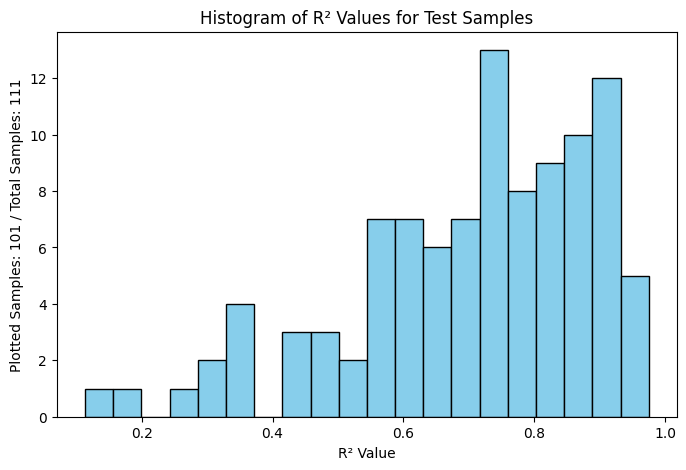

In [348]:
    
# Evaluate model
pred_train_scaled = model.predict(X_train)
pred_test_scaled = model.predict(X_test)

# Inverse transform predictions
pred_train_full = iz_scaler.inverse_transform(pred_train_scaled)
pred_test_full = iz_scaler.inverse_transform(pred_test_scaled)
Iz_train_true = iz_scaler.inverse_transform(Iz_train_scaled)
Iz_test_true = iz_scaler.inverse_transform(Iz_test_scaled)
elapsed = time.time() - t0
print("Elapsed time [mins] = {:.1f} ".format(elapsed/60))

# Compute R² score
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

# Compute R² on scaled data, instead of the actual bi-Gaussian parameters, to avoid distortion from different scales
print("Train R²: {:.2f} %".format(r2_score(Iz_train_scaled.ravel(), pred_train_scaled.ravel()) * 100))
print("Test R²: {:.2f} %".format(r2_score(Iz_test_scaled.ravel(), pred_test_scaled.ravel()) * 100))

# Plot histogram of R² values for each test sample
r2_values = [r2_score(Iz_test_scaled.T.reshape(NCOMP,Iz_test_scaled.shape[0])[:,i], pred_test_scaled.T.reshape(NCOMP,Iz_test_scaled.shape[0])[:,i]) for i in range(Iz_test_scaled.shape[0])]
# Throw away values outside 0 to 1, and count the number of throws
r2_values_new = [r2 for r2 in r2_values if 0 <= r2 <= 1]
num_throws = len(r2_values) - len(r2_values_new)
plt.figure(figsize=(8, 5))
plt.hist(r2_values_new, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of R² Values for Test Samples')
plt.xlabel('R² Value')
plt.ylabel(f'Plotted Samples: {len(r2_values) - num_throws} / Total Samples: {len(r2_values)}')
plt.show()

In [349]:
idx_tmp = 34
print(pred_test_scaled[idx_tmp])
print(pred_test_full[idx_tmp])
print(Iz_train_scaled[idx_tmp])
print(Iz_train_true[idx_tmp])

[0.60248494 0.662652   0.50901195 0.22169374 0.59937519 0.59564315
 0.43885685 0.49610194]
[ 0.5695102  -0.43281003  0.89515872 -1.82694581  0.90023142  0.1661977
  0.19886145  0.32480659]
[0.55687614 0.59617381 0.6701637  0.0213318  0.24196557 0.66672407
 0.32690568 0.41389193]
[-0.05953646 -0.868797    1.83167374 -4.42539692 -4.41314125  0.81139487
 -0.73144037 -0.40021697]


### Plot true vs prediction

In [350]:
from ipywidgets import interact, IntSlider, Layout
def plot_xtcav_image_pred(idx):
    fig, (ax0, ax1, ax2, cx1) = plt.subplots(1,4,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1, 1, 0.02]})

    raw_im = np.flip(LPSimg[valid_rows][ntest[idx]], axis=0)
    im0 = ax0.imshow(raw_im, cmap = "jet",aspect='auto', vmin = 0, vmax = 400)
    ax0.set(ylabel="y [pix]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {ntest[idx]})")


    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = model_cvae.decode_latent_mu(torch.tensor(true_params).unsqueeze(0).float().to(device)).squeeze().cpu().detach().numpy()
    true_im = np.flip(true_im, axis=0)
    im1 = ax1.imshow(true_im, cmap = "jet",aspect='auto', vmin = 0, vmax = 1)

    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"CVAE(Shot Number: {ntest[idx]})")
    # print("True Gaussian Parameters:")
    # true_ug = unflatten_biGaussian_params(true_params)
    # print("Means (Mu):", true_ug['mu'].numpy())
    # print("Covariances (Sigma):", true_ug['Sigma'].numpy())
    # print("Weights (Pi):", true_ug['pi'].numpy())


    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = model_cvae.decode_latent_mu(torch.tensor(pred_params).unsqueeze(0).float().to(device)).squeeze().cpu().detach().numpy()
    pred_im = np.flip(pred_im, axis=0)
    im2 = ax2.imshow(pred_im, cmap = "jet",aspect='auto',vmin = 0, vmax = 1)
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction of CVAE")

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# Create slider
interact(plot_xtcav_image_pred, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0, layout=Layout(width='80%')))

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='80%'), max=110), Output()), _…

<function __main__.plot_xtcav_image_pred(idx)>

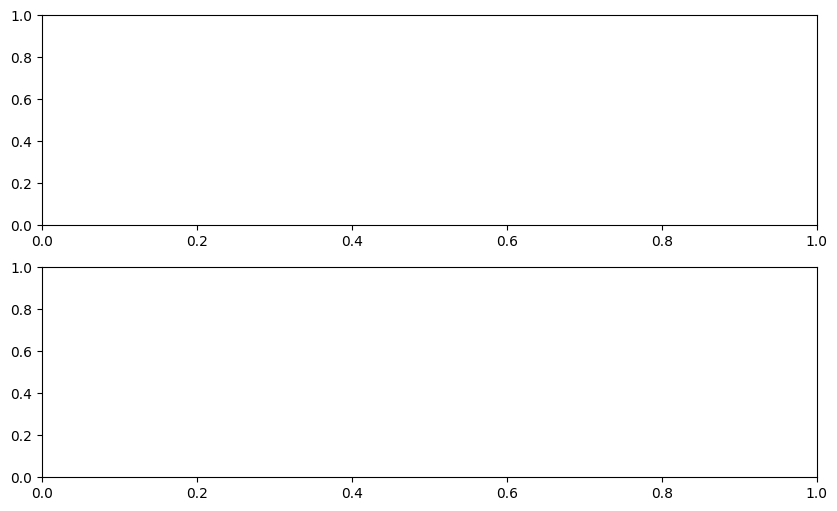

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='80%'), max=110), Output()), _…

<function __main__.plot_xtcav_image_pred_current(idx)>

In [351]:
from ipywidgets import interact, IntSlider, Layout
def plot_xtcav_image_pred_current(idx):
    FACTOR = 1e15
    fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10, 6))

    x_grid = np.linspace(-xrange*xtcalibrationfactor*FACTOR, xrange*xtcalibrationfactor*FACTOR, xrange * 2)
    raw_im = np.flip(LPSimg[valid_rows][ntest[idx]], axis=0)
    raw_im_proj = np.sum(raw_im, axis = 0)
    raw_im_proj = raw_im_proj / np.sum(raw_im_proj)
    # Measure the peak for translation
    peak_index = np.argmax(raw_im_proj)
    if isChargePV:
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        raw_im_proj = raw_im_proj * charge_value * FACTOR
    ax0.plot(x_grid - (peak_index-xrange) * xtcalibrationfactor * FACTOR, raw_im_proj, label = "raw")
    ax0.set(ylabel="Current [A]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {ntest[idx]}) (Total Charge: {charge_value*1e12:.2f} pC)" if isChargePV else f"Raw Image (Shot Number: {ntest[idx]})")

    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    
    if isChargePV:
        # Normalize true image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
    true_im = model_cvae.decode_latent_mu(torch.from_numpy(true_params).float().to(device)).detach().numpy()[0][0]
    true_im_proj = np.sum(true_im, axis = 0)  * FACTOR * charge_value / np.sum(true_im)
    true_peak_index = np.argmax(true_im_proj)
    ax0.plot(x_grid-(true_peak_index-xrange) * xtcalibrationfactor * FACTOR, true_im_proj, label = "fit")


    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
    pred_im = model_cvae.decode_latent_mu(torch.from_numpy(pred_params).float().to(device)).detach().numpy()[0][0]
         
    pred_im_proj = np.sum(pred_im, axis = 0) * FACTOR * charge_value / np.sum(pred_im)
    pred_peak_index = np.argmax(pred_im_proj)
    ax0.plot(x_grid-(pred_peak_index-xrange) * xtcalibrationfactor * FACTOR, pred_im_proj, label = "prediction")
    # Fix x-axis limits
    ax0.set(xlim = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR))
    ax0.legend()

    ax1.imshow(np.flip(raw_im, axis=0), cmap = "jet",aspect='auto', extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 200))

    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

    # Display image_to_bigaussian_params debug info
    #biGaussianTest = image_to_bigaussian_params(images[valid_rows][ntest[idx]].reshape((2*yrange, 2*xrange)), do_current_profile, debug=True)
    #print("Bi-Gaussian Parameters for Test Image:", biGaussianTest)
    

# Create slider
interact(plot_xtcav_image_pred_current, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0, layout=Layout(width='80%')))

### PCA of PV Scalars

Plotting BSA Scalars: TCAV_LI20_2400_P (index 127) and TCAV_LI20_2400_A (index 126)


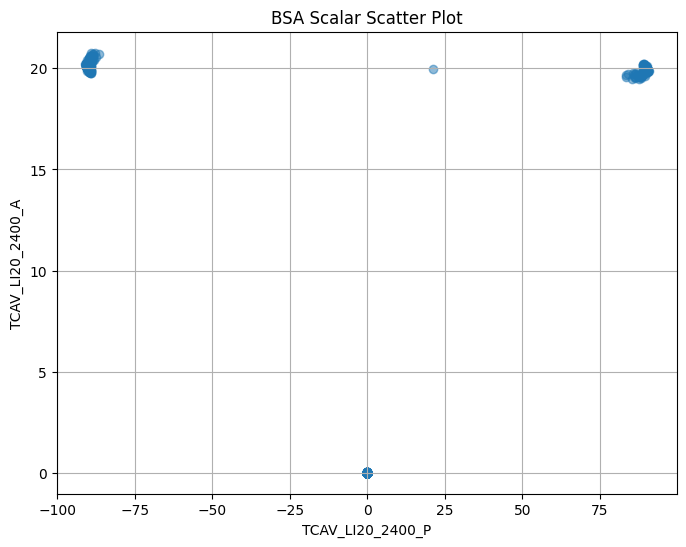

In [352]:
# plot bsaScalarData TCAV_LI20_2400_P and TCAV_LI20_2400_A, most important predictors.
bsaVarNames = bsaVars
var1_name = 'TCAV_LI20_2400_P'
var2_name = 'TCAV_LI20_2400_A'
var1_idx = bsaVarNames.index(var1_name)
var2_idx = bsaVarNames.index(var2_name)
print(f"Plotting BSA Scalars: {var1_name} (index {var1_idx}) and {var2_name} (index {var2_idx})")
plt.figure(figsize=(8,6))
plt.scatter(predictor_tmp[:, var1_idx], predictor_tmp[:, var2_idx], alpha=0.5)
plt.xlabel(var1_name)
plt.ylabel(var2_name)
plt.title('BSA Scalar Scatter Plot')
plt.grid(True)
plt.show()

(554, 110)


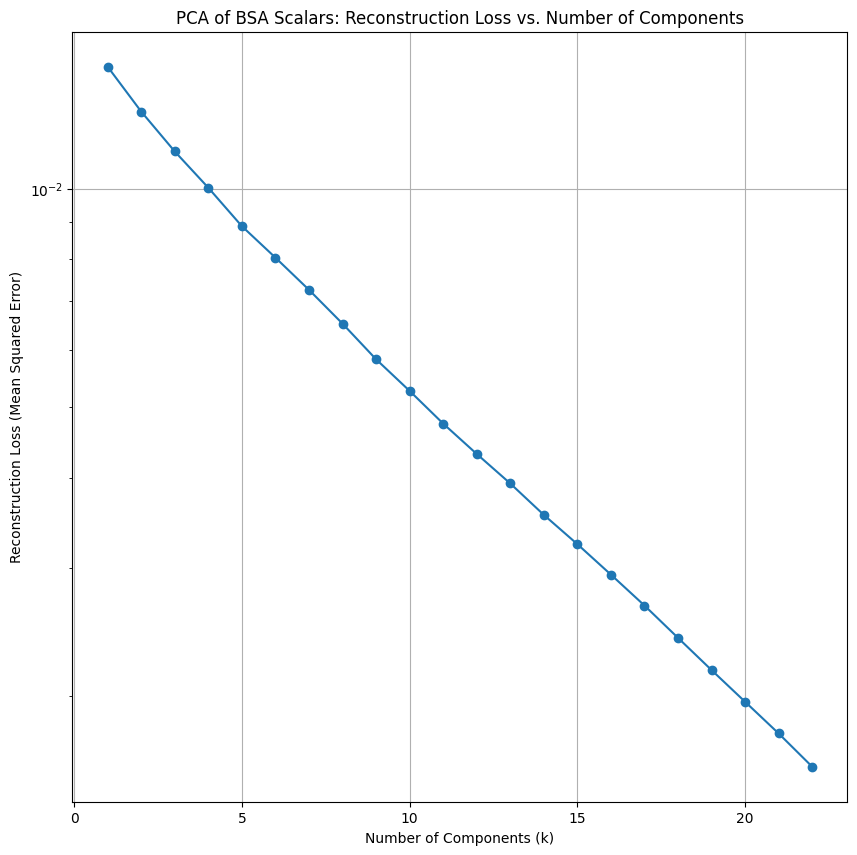

In [353]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming bsaScalarData has shape (N_variables, N_samples) from your function
# Transpose the data so features are columns and samples are rows for scikit-learn PCA
X = predictor_tmp_cleaned
print(X.shape)
bsaVarNames_cleaned = [var for i, var in enumerate(bsaVars) if i not in excluded_var_idx]
# Apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Determine the maximum number of components to test
# X.shape is (N_samples, N_variables). max_components = min(N_samples, N_variables) - 1 for a stable PCA
max_components = min(X.shape) // 5 

# Lists to store results
n_components_list = []
reconstruction_losses = []

# Loop through possible number of components
for k in range(1, max_components + 1):
    # 1. Initialize and fit PCA
    pca_study = PCA(n_components=k)
    pca_study.fit(X)
    
    # 2. Transform and Inverse Transform (Reconstruct)
    X_reduced = pca_study.transform(X)
    X_reconstructed = pca_study.inverse_transform(X_reduced)
    
    # 3. Calculate Reconstruction Loss (Mean Squared Error)
    loss = mean_squared_error(X, X_reconstructed)
    
    # Store results
    n_components_list.append(k)
    reconstruction_losses.append(loss)
    
# 4. Plot the Results
plt.figure(figsize=(10, 10))
plt.plot(n_components_list, reconstruction_losses, marker='o', linestyle='-')
plt.xlabel('Number of Components (k)')
plt.ylabel('Reconstruction Loss (Mean Squared Error)')
# Log scale in y-axis for better visualization
plt.yscale('log')
plt.title('PCA of BSA Scalars: Reconstruction Loss vs. Number of Components')
plt.grid(True)
# 5. Identify the "Elbow" point visually after plotting plt.show()
plt.show() 

# After plotting, the optimal number of components is the 'elbow' point.

In [354]:

num_components = 11

pca_comp_study = PCA(n_components=num_components)
X_pca = pca_comp_study.fit_transform(X)
# 1. Get explained variance and component loadings

variance_ratios = pca_comp_study.explained_variance_ratio_
loadings = pca_comp_study.components_

# 2. Create the DataFrame for component composition
# Each row in 'loadings' is a principal component (PC)
# Each column corresponds to a feature (PV)
df_loadings = pd.DataFrame(loadings, columns=bsaVarNames_cleaned)

# 3. Add Component labels and Significance
component_labels = [f'PC {i+1}' for i in range(num_components)]
df_loadings.insert(0, 'Component', component_labels)
df_loadings.insert(1, 'Significance (Explained Variance Ratio)', variance_ratios)

# 4. Format the output
# The components are already ordered by significance (PC 1 is most significant)
# Format the significance column as a percentage for clarity
df_loadings['Significance (Explained Variance Ratio)'] = \
    df_loadings['Significance (Explained Variance Ratio)'].map(lambda x: f'{x:.4f} ({x*100:.2f}%)')

# Format the loadings to a fixed number of decimal places
for col in bsaVarNames_cleaned:
    df_loadings[col] = df_loadings[col].map(lambda x: f'{x:.4f}')

# Display the resulting table
composition_table = df_loadings.to_markdown(index=False)
print("Composition of Principal Components:")
print(composition_table)

Composition of Principal Components:
| Component   | Significance (Explained Variance Ratio)   |   TORO_IN10_431_TMIT |   TORO_IN10_591_TMIT |   TORO_IN10_791_TMIT |   BPMS_IN10_221_X |   BPMS_IN10_221_Y |   BPMS_IN10_221_TMIT |   BPMS_IN10_371_X |   BPMS_IN10_371_Y |   BPMS_IN10_371_TMIT |   BPMS_IN10_425_X |   BPMS_IN10_425_Y |   BPMS_IN10_425_TMIT |   BPMS_IN10_511_X |   BPMS_IN10_511_Y |   BPMS_IN10_511_TMIT |   BPMS_IN10_525_X |   BPMS_IN10_525_Y |   BPMS_IN10_525_TMIT |   BPMS_IN10_581_X |   BPMS_IN10_581_Y |   BPMS_IN10_581_TMIT |   BPMS_IN10_631_X |   BPMS_IN10_631_Y |   BPMS_IN10_631_TMIT |   BPMS_IN10_651_X |   BPMS_IN10_651_Y |   BPMS_IN10_651_TMIT |   BPMS_IN10_731_X |   BPMS_IN10_731_Y |   BPMS_IN10_731_TMIT |   BPMS_IN10_771_X |   BPMS_IN10_771_Y |   BPMS_IN10_771_TMIT |   BLEN_IN10_596_BRAW |   BPMS_IN10_781_X |   BPMS_IN10_781_Y |   BPMS_IN10_781_TMIT |   PMTR_HT10_950_PWR |   LASR_LT10_930_PWR |   KLYS_LI10_21_FB_FAST_PACT |   KLYS_LI10_21_FB_FAST_AACT |   ACCL_LI10_21

In [355]:
# 1. Extract and Square the Loadings (Loadings matrix is: Components x Variables)
# loadings = pca_comp_study.components_ (from your provided code block)
squared_loadings = loadings**2

# 2. Sum Across Components (Sum columns to get total significance per variable)
# The result is an array where each element is the total squared loading for a variable
total_squared_loadings = np.sum(squared_loadings, axis=0)
print(total_squared_loadings.shape)
# 3. Create a DataFrame for sorting
# bsaVars is the list of variable names (features)
df_var_significance = pd.DataFrame({
    'BSA Variable (PV)': bsaVarNames_cleaned,
    'Total Squared Loading (Significance)': total_squared_loadings
})

# 4. Sort in descending order
df_var_significance = df_var_significance.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 5. Specify the number of top variables to display
N_top = 20  # Example: display the top few most significant variables

# 6. Format and display the table
df_top_vars = df_var_significance.head(N_top)
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

inverted_table = df_top_vars.to_markdown(index=False)
print(f"Top {N_top} BSA Variables Ordered by Significance in PCA Components:")
print(inverted_table)


(110,)
Top 20 BSA Variables Ordered by Significance in PCA Components:
| BSA Variable (PV)           |   Total Squared Loading (Significance) |
|:----------------------------|---------------------------------------:|
| BLEN_LI11_359_BRAW          |                                 0.9943 |
| PMT_LI20_3070_QDCRAW        |                                 0.8943 |
| LASR_LT10_930_PWR           |                                 0.5957 |
| KLYS_LI10_41_FB_FAST_PACT   |                                 0.4288 |
| PMTR_HT10_950_PWR           |                                 0.3918 |
| ACCL_LI10_21_W0C6_FAST_AACT |                                 0.3778 |
| KLYS_LI10_21_FB_FAST_PACT   |                                 0.3646 |
| KLYS_LI10_41_FB_FAST_AACT   |                                 0.3433 |
| KLYS_LI10_31_FB_FAST_AACT   |                                 0.3067 |
| KLYS_LI10_21_FB_FAST_AACT   |                                 0.2991 |
| BPMS_IN10_371_X             |                      

/tmp/ipykernel_975/570667637.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_vars['Total Squared Loading (Significance)'] = \


In [356]:

df_filtered = df_var_significance[
    ~df_var_significance['BSA Variable (PV)'].str.contains('BPM', case=False, na=False)
]

# 5. Sort the filtered variables in descending order of significance
df_filtered = df_filtered.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 6. Select Top N and format
N_top = 20 # Display the top few most significant non-BPM variables
df_top_vars = df_filtered.head(N_top)

# Format the significance column
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

# Display the resulting table
inverted_table = df_top_vars.to_markdown(index=False)

print(f"Top {N_top} BSA Variables (EXCLUDING BPMS) Ordered by Significance in PCA Components:")
print(inverted_table)

Top 20 BSA Variables (EXCLUDING BPMS) Ordered by Significance in PCA Components:
| BSA Variable (PV)           |   Total Squared Loading (Significance) |
|:----------------------------|---------------------------------------:|
| BLEN_LI11_359_BRAW          |                                 0.9943 |
| PMT_LI20_3070_QDCRAW        |                                 0.8943 |
| LASR_LT10_930_PWR           |                                 0.5957 |
| KLYS_LI10_41_FB_FAST_PACT   |                                 0.4288 |
| PMTR_HT10_950_PWR           |                                 0.3918 |
| ACCL_LI10_21_W0C6_FAST_AACT |                                 0.3778 |
| KLYS_LI10_21_FB_FAST_PACT   |                                 0.3646 |
| KLYS_LI10_41_FB_FAST_AACT   |                                 0.3433 |
| KLYS_LI10_31_FB_FAST_AACT   |                                 0.3067 |
| KLYS_LI10_21_FB_FAST_AACT   |                                 0.2991 |
| ACCL_LI10_41_W0C0_FAST_AACT |            

/tmp/ipykernel_975/2531780689.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_vars['Total Squared Loading (Significance)'] = \


--- Dynamic ML Prediction Explorer ---
Adjust the sliders below to see the real-time effect on the LPS profile prediction.


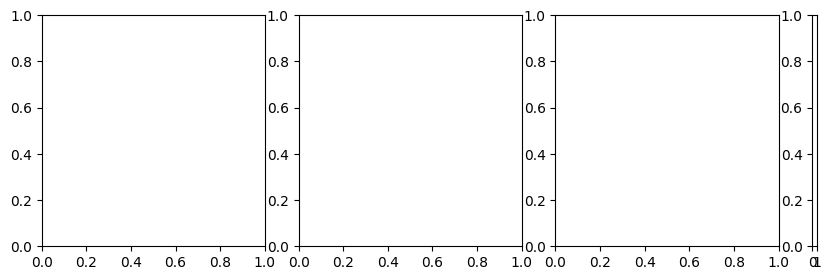

interactive(children=(FloatSlider(value=4965.140625, description='BLEN_LI11_359_BRAW', layout=Layout(width='90…

<function __main__.plot_dynamic_pred(**slider_values)>

In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from ipywidgets import interact, IntSlider, FloatSlider, Layout
import torch

index_to_examine = 1  # Change this index to examine different test samples

# Variables to be controlled (Non-BPM variables from previous ranking logic)
CONTROL_VARS = [
    'BLEN_LI11_359_BRAW', 
    'LASR_LT10_930_PWR', 'PMTR_HT10_950_PWR', 
    'KLYS_LI10_41_FB_FAST_PACT', 'KLYS_LI10_41_FB_FAST_AACT'
]
# ==============================================================================
# --- DYNAMIC PREDICTION FUNCTION ---
# ==============================================================================
original_predictor_reconstructed = x_scaler.inverse_transform(X_test.numpy())
def plot_dynamic_pred(**slider_values):
    idx = index_to_examine
    fig, (ax1, ax2,ax3, cx1) = plt.subplots(1,4,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1,1, 0.02]})
    
    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = model_cvae.decode_latent_mu(true_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(true_im)
        true_im = true_im / pred_im_sum * charge_value
         
    im1 = ax1.imshow(true_im, cmap = "jet",aspect='auto')
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")
    ax1.set(xlim = (0,2*xrange))
    ax1.set(ylim= (0,2*yrange))

    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = model_cvae.decode_latent_mu(pred_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(pred_im)
        pred_im = pred_im / pred_im_sum * charge_value
    im2 = ax2.imshow(pred_im, cmap = "jet",aspect='auto')
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")
    ax2.set(xlim = (0,2*xrange))
    ax2.set(ylim= (0,2*yrange))

    # Modify the predictor for the given index based on slider values
    modified_predictor = original_predictor_reconstructed[idx].copy()
    for var_name, slider in slider_values.items():
        pv_index = bsaVarNames_cleaned.index(var_name)
        modified_predictor[pv_index] = slider

    # Scale back the modified predictor
    modified_predictor_scaled = x_scaler.transform(modified_predictor.reshape(1, -1))

    # Make prediction with modified predictor
    modified_predictor_tensor = torch.tensor(modified_predictor_scaled, dtype=torch.float32)
    with torch.no_grad():
        modified_pred_scaled = model(modified_predictor_tensor).numpy()
    modified_pred_full = iz_scaler.inverse_transform(modified_pred_scaled)
    modified_pred_params = modified_pred_full[0]
    print(modified_pred_params)
    modified_pred_im = model_cvae.decode_latent_mu(modified_pred_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        modified_pred_im_sum = np.sum(modified_pred_im)
        modified_pred_im = modified_pred_im / modified_pred_im_sum * charge_value
    im3 = ax3.imshow(modified_pred_im, cmap = "jet",aspect='auto')
    ax3.set(xlabel = "Time [fs]")
    ax3.set(ylabel = "y [pix]")
    ax3.set(title = "Modified Prediction")
    ax3.set(xlim = (0,2*xrange))
    ax3.set(ylim= (0,2*yrange))

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# ==============================================================================
# --- INTERACTIVE WIDGET SETUP ---
# ==============================================================================

# 1. Calculate min/max for sliders (using the mock raw data)
raw_min_max = {}
for i, pv_name in enumerate(CONTROL_VARS):
    pv_index = bsaVarNames_cleaned.index(pv_name)
    raw_min_max[pv_name] = (predictor_tmp[:, pv_index].min(), predictor_tmp[:, pv_index].max())

N_SAMPLES = Iz_test_true.shape[0]

# 2. Setup the Widgets
widget_kwargs = {}  # Fixed index for demonstration

for i, pv_name in enumerate(CONTROL_VARS):
    min_val, max_val = raw_min_max[pv_name]
    pv_index = bsaVarNames_cleaned.index(pv_name)
    # Initial value is the mean of the range, as we cannot predict 
    # the X_test[idx] value without dynamic input in the slider setup.
    # We set it to 0.0 (or mid-range) and rely on the plot_dynamic_pred 
    # function to construct the input correctly.
    initial_value = original_predictor_reconstructed[index_to_examine, pv_index] # Use the value for the initial index (idx=0)
    
    widget_kwargs[pv_name] = FloatSlider(
        min=min_val, 
        max=max_val, 
        step=(max_val - min_val) / 100.0, # 100 steps granularity
        value=initial_value,
        description=pv_name,
        readout_format='.4f',
        layout=Layout(width='90%')
    )

print("--- Dynamic ML Prediction Explorer ---")
print("Adjust the sliders below to see the real-time effect on the LPS profile prediction.")

# 3. Create the Interactive Interface
# Note: The widget values are passed as keyword arguments to plot_dynamic_pred
interact(plot_dynamic_pred, **widget_kwargs)

--- Dynamic ML Prediction Explorer ---
Adjust the sliders below to see the real-time effect on the LPS profile prediction.


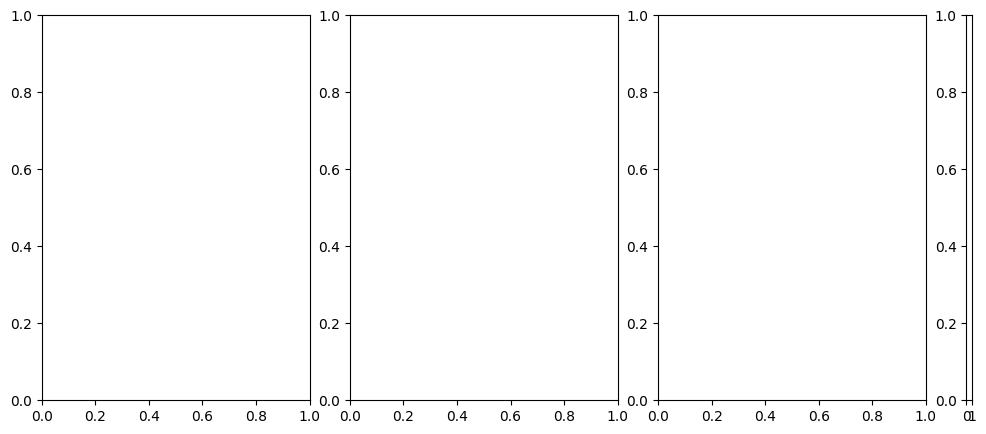

interactive(children=(FloatSlider(value=0.37565666024052563, description='PC1', layout=Layout(width='90%'), ma…

<function __main__.plot_dynamic_pred(**slider_values)>

In [358]:

index_to_examine = 80  # Change this index to examine different test samples

# Variables to be controlled (Non-BPM variables from previous ranking logic)
# ==============================================================================
# --- DYNAMIC PREDICTION FUNCTION ---
# ==============================================================================
original_predictor_reconstructed = x_scaler.inverse_transform(X_test.numpy())
def plot_dynamic_pred(**slider_values):
    idx = index_to_examine
    fig, (ax1, ax2,ax3, cx1) = plt.subplots(1,4,figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1,1, 0.02]})
    
    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = model_cvae.decode_latent_mu(true_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(true_im)
        true_im = true_im / pred_im_sum * charge_value
         
    im1 = ax1.imshow(true_im, cmap = "jet",aspect='auto')
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")
    ax1.set(xlim = (0,2*xrange))
    ax1.set(ylim= (0,2*yrange))

    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = model_cvae.decode_latent_mu(pred_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(pred_im)
        pred_im = pred_im / pred_im_sum * charge_value
    im2 = ax2.imshow(pred_im, cmap = "jet",aspect='auto')
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")
    ax2.set(xlim = (0,2*xrange))
    ax2.set(ylim= (0,2*yrange))

    # Modify the predictor for the given index based on slider values
    pca_components = []
    for var_name, slider in slider_values.items():
        # Reconstruct the original predictor values from PCA components
        pca_components.append(slider)
    pca_components = np.array(pca_components).reshape(1, -1)
    modified_predictor = pca_comp_study.inverse_transform(pca_components).flatten()


    # Scale back the modified predictor
    modified_predictor_scaled = modified_predictor.reshape(1, -1)

    # Make prediction with modified predictor
    modified_predictor_tensor = torch.tensor(modified_predictor_scaled, dtype=torch.float32)
    with torch.no_grad():
        modified_pred_scaled = model(modified_predictor_tensor).numpy()
    modified_pred_full = iz_scaler.inverse_transform(modified_pred_scaled)
    modified_pred_params = modified_pred_full[0]

    # Print the modified parameters minus the original predicted parameters for comparison
    print("Difference in Parameters from Original Prediction:")
    for i, name in enumerate(["pi_1", "pi_2", "mu_1_x", "mu_1_y", "sigma_1_xx", "sigma_1_xy", "sigma_1_yy", "sigma_2_xx", "sigma_2_xy", "sigma_2_yy"]):
        diff = modified_pred_params[i] - pred_params[i]
        print(f"{name}: {diff:.4f}")

    modified_pred_im = model_cvae.decode_latent_mu(modified_pred_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        modified_pred_im_sum = np.sum(modified_pred_im)
        modified_pred_im = modified_pred_im / modified_pred_im_sum * charge_value
    im3 = ax3.imshow(modified_pred_im, cmap = "jet",aspect='auto')
    ax3.set(xlabel = "Time [fs]")
    ax3.set(ylabel = "y [pix]")
    ax3.set(title = "Modified Prediction")
    ax3.set(xlim = (0,2*xrange))
    ax3.set(ylim= (0,2*yrange))

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# ==============================================================================
# --- INTERACTIVE WIDGET SETUP ---
# ==============================================================================
# 1. Calculate min/max for sliders (using the mock raw data)

N_SAMPLES = Iz_test_true.shape[0]
pca_vals = pca_comp_study.transform(X_test.numpy())
# 2. Setup the Widgets
widget_kwargs = {}  # Fixed index for demonstration

for i in range(pca_comp_study.components_.shape[0]):
    pv_name = f"PC{i+1}"
    pv_index = i
    min_val, max_val = pca_vals[:, pv_index].min(), pca_vals[:, pv_index].max()
    # Initial value is the mean of the range, as we cannot predict 
    # the X_test[idx] value without dynamic input in the slider setup.
    # We set it to 0.0 (or mid-range) and rely on the plot_dynamic_pred 
    # function to construct the input correctly.
    initial_value = pca_vals[index_to_examine, pv_index] # Use the value for the initial index (idx=0)
    
    widget_kwargs[pv_name] = FloatSlider(
        min=min_val, 
        max=max_val, 
        step=(max_val - min_val) / 100.0, # 100 steps granularity
        value=initial_value,
        description=pv_name,
        readout_format='.4f',
        layout=Layout(width='90%')
    )

print("--- Dynamic ML Prediction Explorer ---")
print("Adjust the sliders below to see the real-time effect on the LPS profile prediction.")

# 3. Create the Interactive Interface
# Note: The widget values are passed as keyword arguments to plot_dynamic_pred
interact(plot_dynamic_pred, **widget_kwargs)

In [359]:
raise ImportError("Stop here")

ImportError: Stop here

In [ ]:
# Save the model and scalers
import time
import joblib
import pickle
time_stamp = time.strftime("%Y%m%d_%H%M%S")
joblib_file = '../../model/LPS/MLP_LPS_CVAE_Forest_'+experiment+'_'+runname+'_'+time_stamp+'.pkl'  
joblib.dump(model, joblib_file)
joblib_file_2 = '../../model/LPS/MLP_LPS_CVAE_'+experiment+'_'+runname+'_'+time_stamp+'.pkl' 
joblib.dump(model_cvae, joblib_file_2) 
iz_scaler_file = '../../model/LPS/' + experiment + '_' + runname + '_iz_scaler_CVAE_'+time_stamp+'.pkl'
pickle.dump(iz_scaler, open(iz_scaler_file,"wb"))

### Save Desired LPS Image

In [ ]:
# Display LPS Images with sliders and a button to save the current image as pickle
from ipywidgets import interact, IntSlider, Layout, Button
import matplotlib.pyplot as plt
import numpy as np
def plot_xtcav_image_save(idx):
    fig, (ax0, cx1) = plt.subplots(1,2,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 0.02]})

    raw_im = np.flip(LPSimg[valid_rows][idx], axis=0)
    im0 = ax0.imshow(raw_im, cmap = "gray",aspect='auto')
    ax0.set(ylabel="y [pix]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {idx})")

    cbar = fig.colorbar(im0, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
# Add a button to save the current figure
def save_current_figure(b):
    idx = slider_idx.value
    # Save the LPS image as PNG
    raw_im = np.flip(LPSimg[valid_rows][idx], axis=0)
    filename = f'LPS_Image_{experiment}_{runname}_Shot_{idx}.png'
    plt.imsave(filename, raw_im, cmap='jet')
    print(f"Saved LPS image for shot {idx} as {filename}")
slider_idx = IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0, layout=Layout(width='80%'))
interact(plot_xtcav_image_save, idx=slider_idx)
button_save = Button(description="Save Current Figure as PNG")
button_save.on_click(save_current_figure)
display(button_save)

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='80%'), max=110), Output()), _…

Button(description='Save Current Figure as PNG', style=ButtonStyle())

### Load LPS Image and Search...

In [ ]:
# Load LPS Image from PNG file
from PIL import Image
import numpy as np
def load_lps_image_from_png(file_path):
    # Load image using PIL
    img = Image.open(file_path).convert('L') 
    img_array = np.array(img)
    # Normalize the image to [0, 1]
    img_array = img_array / 255.0
    return img_array
# Example usage:
file_path = 'path_to_your_lps_image.png'  # Replace with your file path
lps_image_desired = load_lps_image_from_png(file_path)

In [ ]:
# distance between LPS images in the dataset
threshold_distance = 5  # Adjust based on dataset specifics
def find_operation_points(lps_image, dataset_images, threshold):
    operation_points = []
    for i, img in enumerate(dataset_images):
        distance = proj_vae_loss(torch.tensor(lps_image).unsqueeze(0).float().to(device),
                                 torch.tensor(img).unsqueeze(0).float().to(device)).item()
        if distance < threshold:
            operation_points.append(i)  # Return the index of the matching operation point
    return operation_points  # Return all matching operation points

# Take distances in the PCA of predictor space after MinMax scaling, given desired operation points and current operation point
def find_nearest_operation_point(desired_points, current_predictor, predictor_data):
    predictor_data_pca = pca_comp_study.transform(predictor_data)
    current_point_pca = pca_comp_study.transform(current_predictor.reshape(1, -1)).flatten()
    nearest_point = None
    min_distance = float('inf')
    for point in desired_points:
        desired_vector = predictor_data_pca[point]
        distance = np.linalg.norm(current_point_pca - desired_vector)
        if distance < min_distance:
            min_distance = distance
            nearest_point = point
    return nearest_point